# Data Challenge
## Publication Venue Prediction Challenge
* Koutsomarkos Alexandros : akoutsomarkos@aueb.gr
* Lakkas Ioannis : ilakkas@aueb.gr

### Basic Imports

In [1]:
!pip install -q scikeras

In [2]:
# basic libraries
import csv
import numpy as np
import string
import re
from tqdm import tqdm
from random import choice
from scipy import sparse
from collections import Counter
from pylab import rcParams
import random
import matplotlib.pyplot as plt
import pandas as pd
import time

# nltk 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

# warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.exceptions
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE, Isomap
warnings.filterwarnings("ignore", category = sklearn.exceptions.UndefinedMetricWarning)
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.decomposition import TruncatedSVD

# XGB
from xgboost import XGBClassifier

# Gensim 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec

# networkx (graph)
import networkx as nx

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, Reshape, Dropout, Add, LayerNormalization, Embedding

# SMOTE
from imblearn.over_sampling import SMOTE

# LGBM
import lightgbm as lgb

# keras
from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

# seaborn
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
#change the directory accordingly
os.chdir('/content/drive/Othercomputers/My MacBook Air/MSc_Data_Science/2ndYear/April-June_PT12021-2023/Data Challenge/data_challenge_aueb_2023')

Mounted at /content/drive


In [4]:
cachedStopWords = stopwords.words("english")

* Set random seed equal to 42

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Text cleaning functions

* Replace all multiple white spaces from text and keep only one

In [6]:
def replace_multiple_spaces_with_single(text: str) -> str:
    """
    Method replaces multiple spaces with a single one

    Args
        | text (str): the text to be processed

    Returns
        | str: the new text where multiple spaces are removed
    """
    if text is None:
        return text
    return re.sub(' +', ' ', str(text))

* Text cleaning method, which cleans the text. Actually it converts the text into lower case, removes all unnecessary characters-words (single characters, punctuation, stopwords, numbers) and finally lemmatize all the words.

In [7]:
def text_cleaning(text: str):
    #convert to lower case
    text = text.lower()
    # remove parentheses with text (and brackets)
    text = re.sub("[\(\[].*?[\)\]]", " ", text)
    # remove all non words
    text = re.sub(r'\W', ' ', text)
    # remove all single characters
    text = re.sub(r'\b\w\b', ' ', text)
    # remove - 
    text = text.replace('-', ' ')
    # remove punctuation
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans(" ", " ", PUNCT_TO_REMOVE))
    #remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    text_tokens = word_tokenize(text)
    # remove stopwords
    text = ' '.join([word for word in text_tokens if not word in cachedStopWords])
    # lematization
    text = text.split()
    text = ' '.join([stemmer.lemmatize(word) for word in text])
    # remove extra spaces
    text = replace_multiple_spaces_with_single(text)
    text = text.strip()
    return text

### Read the data

#### Authors

In [8]:
authors = dict()
with open("authors_v2.txt", "r", encoding='utf-8') as f:
    for line in f:
        #print(line)
        t = line.split('||')
        authors[int(t[0])] = t[1][:-1]

#### Abstracts

In [9]:
abstracts = dict()
with open("abstracts.txt", "r", encoding='utf-8') as f:
    for line in f:
        #print(line)
        t = line.split('||')
        abstracts[int(t[0])] = t[1][:-1]

#### Read years

In [10]:
year = dict()
with open("year.txt", "r", encoding='utf-8') as f:
    for line in f:
        t = line.split(',')
        year[int(t[0])] = int(t[1][:-1])

#### Read edgelist

In [11]:
# Create a directed graph
G = nx.read_edgelist("edgelist.txt", nodetype=int, create_using=nx.DiGraph)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 166986
Number of edges: 591017


#### Read train data

In [12]:
# Read training data
train_papers = list()
y_train = list()
ids_y = {}
with open("y_train.txt", "r") as f:
    for line in f:
        t = line.split(',')
        train_papers.append(int(t[0]))
        y_train.append(t[1][:-1])
        ids_y[int(t[0])] = t[1][:-1]

#### Read test data

In [13]:
# Read test data
test_papers = list()
with open("test.txt", "r") as f:
    for line in f:
        t = line.split(',')
        test_papers.append(int(t[0]))

### Exploratory Data Analysis (EDA)

#### Plot graphs

* Create a subgraph of G (using only 200 nodes for presentation purposes) along with their labels

In [ ]:
# Extract subgraph
sub_G = nx.subgraph(G, [n for n in G.nodes if n in train_papers][200:400])
# Get the labels of the nodes in the subgraph -- will be useful for coloring
sub_labels = [int(ids_y[n]) for n in sub_G.nodes]

* Plot the subgraph using different colors for each label and also different node size for the most "famous" nodes (nodes with high degree values) in this subgraph.

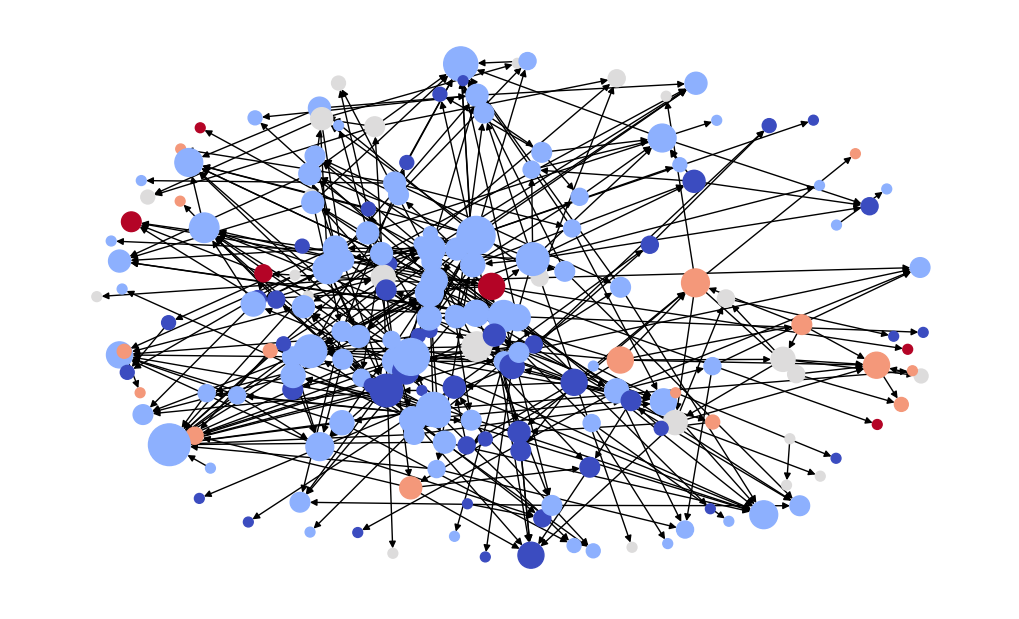

In [ ]:
# Set size of the plot
rcParams['figure.figsize'] = 10, 6
# create a layout for the nodes
pos = nx.spring_layout(sub_G, scale=20, k=3/np.sqrt(sub_G.order()))
# set size of the node to be drawn proportional to degree
node_size = [sub_G.degree[v] * 50 for v in sub_G.nodes]
# draw the graph, and color nodes by labels
nx.draw(sub_G, pos, node_size=node_size, node_color = sub_labels, cmap = plt.get_cmap('coolwarm'))
plt.savefig("Graph.png", format="PNG")

* Create a Word2Vec model using the abstracts and a vector_size equal to 128 to create features for each node.

In [ ]:
# Represent each abstract as a list of words
abstracts_list = {}
for node in abstracts:
    abstracts_list[node] = abstracts[node].split()

In [ ]:
model = Word2Vec(sentences=abstracts_list.values(), vector_size=128, window = 5, min_count=3, workers = 8, epochs=5, sg=1)

* Create features for each node, using the Word2Vec model and keeping the average embedding for each node

In [ ]:
features_train = {}
for node in G.nodes():
    features_train[node] = np.random.randn(128)
    n_words = 0
    for word in abstracts_list[node]:
        if word in model.wv:
            features_train[node] += model.wv[word]
            n_words += 1
    if n_words > 0:
        features_train[node] /= n_words 

* Plot of the papers based on these features using the tSNE. t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space. It is particularly effective in revealing patterns, clusters, or relationships that may be present in the data. By modeling the similarities between data points in the original high-dimensional space and mapping them to a lower-dimensional space (usually 2D or 3D), t-SNE aims to preserve the local structure of the data while spreading out dissimilar points. This allows for the visualization of complex datasets and can help identify hidden patterns or groupings that may not be apparent in the original feature space. The TSNE(2) function call in the given code snippet generates a 2D t-SNE representation of the data, providing a visual representation of the relationships and similarities between the research papers based on their features or embeddings.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 35163 samples in 0.004s...
[t-SNE] Computed neighbors for 35163 samples in 15.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35163
[t-SNE] Computed conditional probabilities for sample 2000 / 35163
[t-SNE] Computed conditional probabilities for sample 3000 / 35163
[t-SNE] Computed conditional probabilities for sample 4000 / 35163
[t-SNE] Computed conditional probabilities for sample 5000 / 35163
[t-SNE] Computed conditional probabilities for sample 6000 / 35163
[t-SNE] Computed conditional probabilities for sample 7000 / 35163
[t-SNE] Computed conditional probabilities for sample 8000 / 35163
[t-SNE] Computed conditional probabilities for sample 9000 / 35163
[t-SNE] Computed conditional probabilities for sample 10000 / 35163
[t-SNE] Computed conditional probabilities for sample 11000 / 35163
[t-SNE] Computed conditional probabilities for sample 12000 / 35163
[t-SNE] Computed conditional probabilities for sa

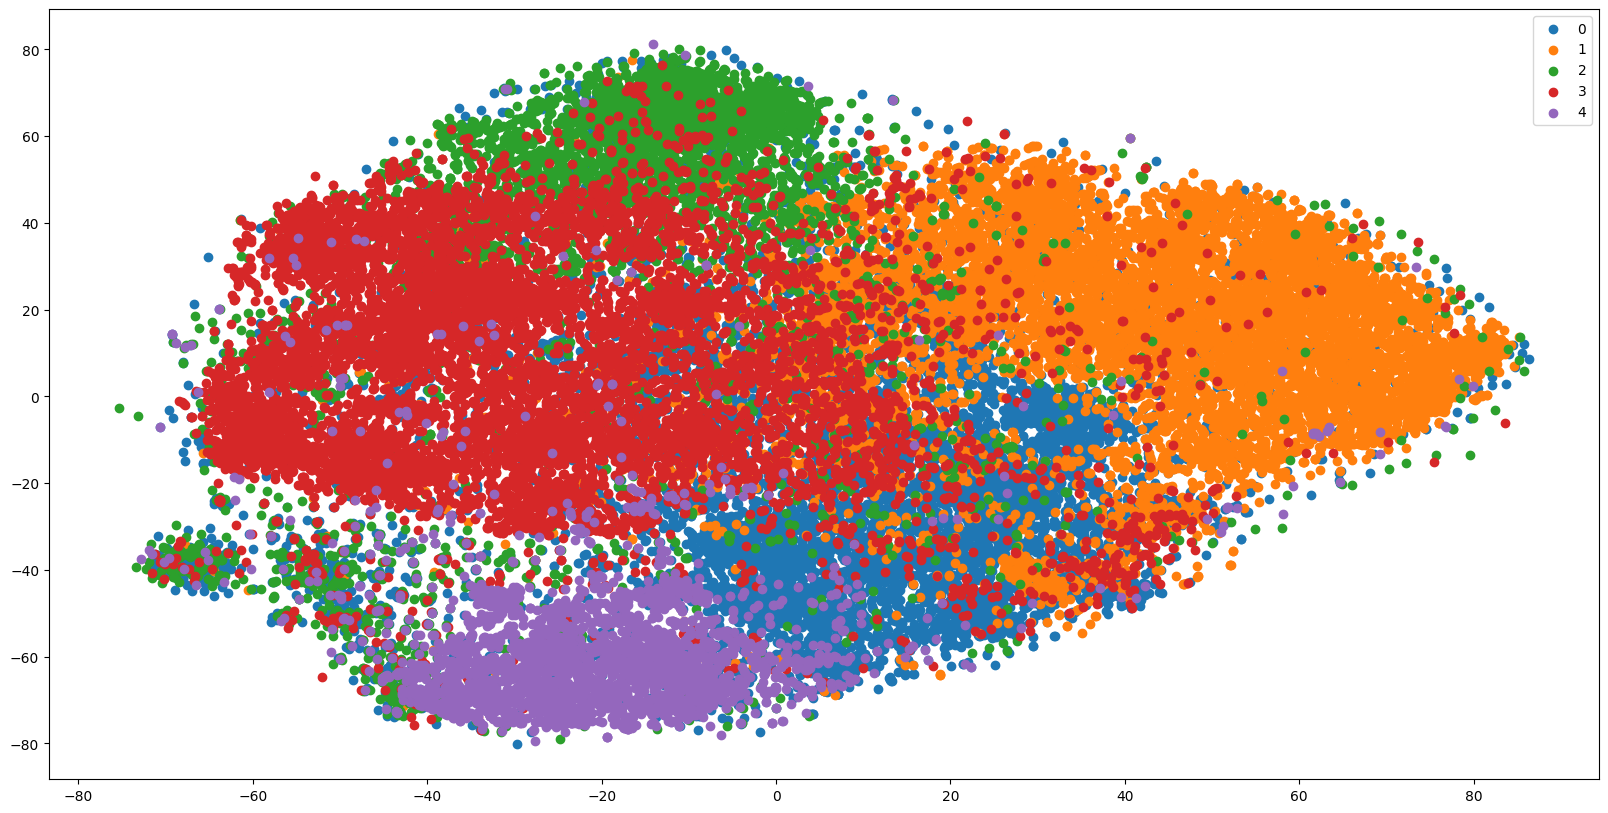

In [ ]:
# Set size of the plot
rcParams['figure.figsize'] = 20, 10

sub_G_tsne = nx.subgraph(G, [n for n in G.nodes if n in train_papers][:50000])
# Get the labels of the nodes in the subgraph -- will be useful for coloring
sub_labels = [int(ids_y[n]) for n in sub_G_tsne.nodes]
# collect the features of the nodes
sub_features = [features_train[n] for n in sub_G_tsne.nodes]

# Generate 2d tSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(np.array(sub_features))

# Plot the points as a scatter plot and label them based on the labels
for label in np.unique(sub_labels): 
    i = np.where(sub_labels == label)
    plt.scatter(tsne_proj[i,0], tsne_proj[i,1], label = label)
plt.legend()
fig1 = plt.gcf()
plt.show()

fig1.savefig('tSNE2.png')

#### Plot class distribution

In [14]:
count = Counter(y_train)
df = pd.DataFrame.from_dict(count, orient='index')
df = df.sort_index()

*  We can observe that in this dataset, the number of samples in each class (corresponding to different publication venues) ranges between 3,203 and 9,825, indicating an inherent class imbalance.

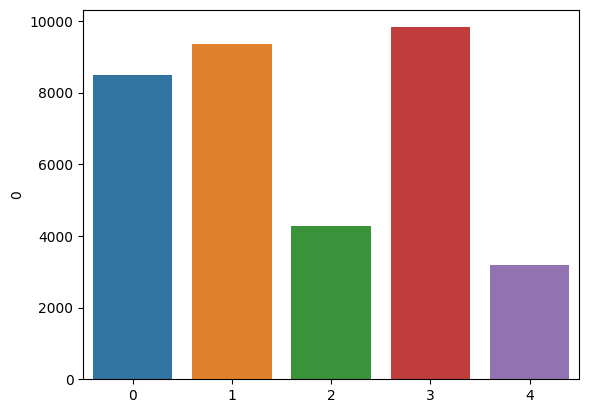

In [15]:
sns.barplot(data=df, x=df.index, y=df[0]).figure.savefig("class.png")

#### Plot years distribution

In [16]:
count = Counter(year)
year_df = pd.DataFrame.from_dict(count, orient='index')
year_df = year_df.sort_index()

* We can observe that we have paper which has been published into 1940 and also we can observe that the more papers are from 2000 until 2022 (which sounds logical)

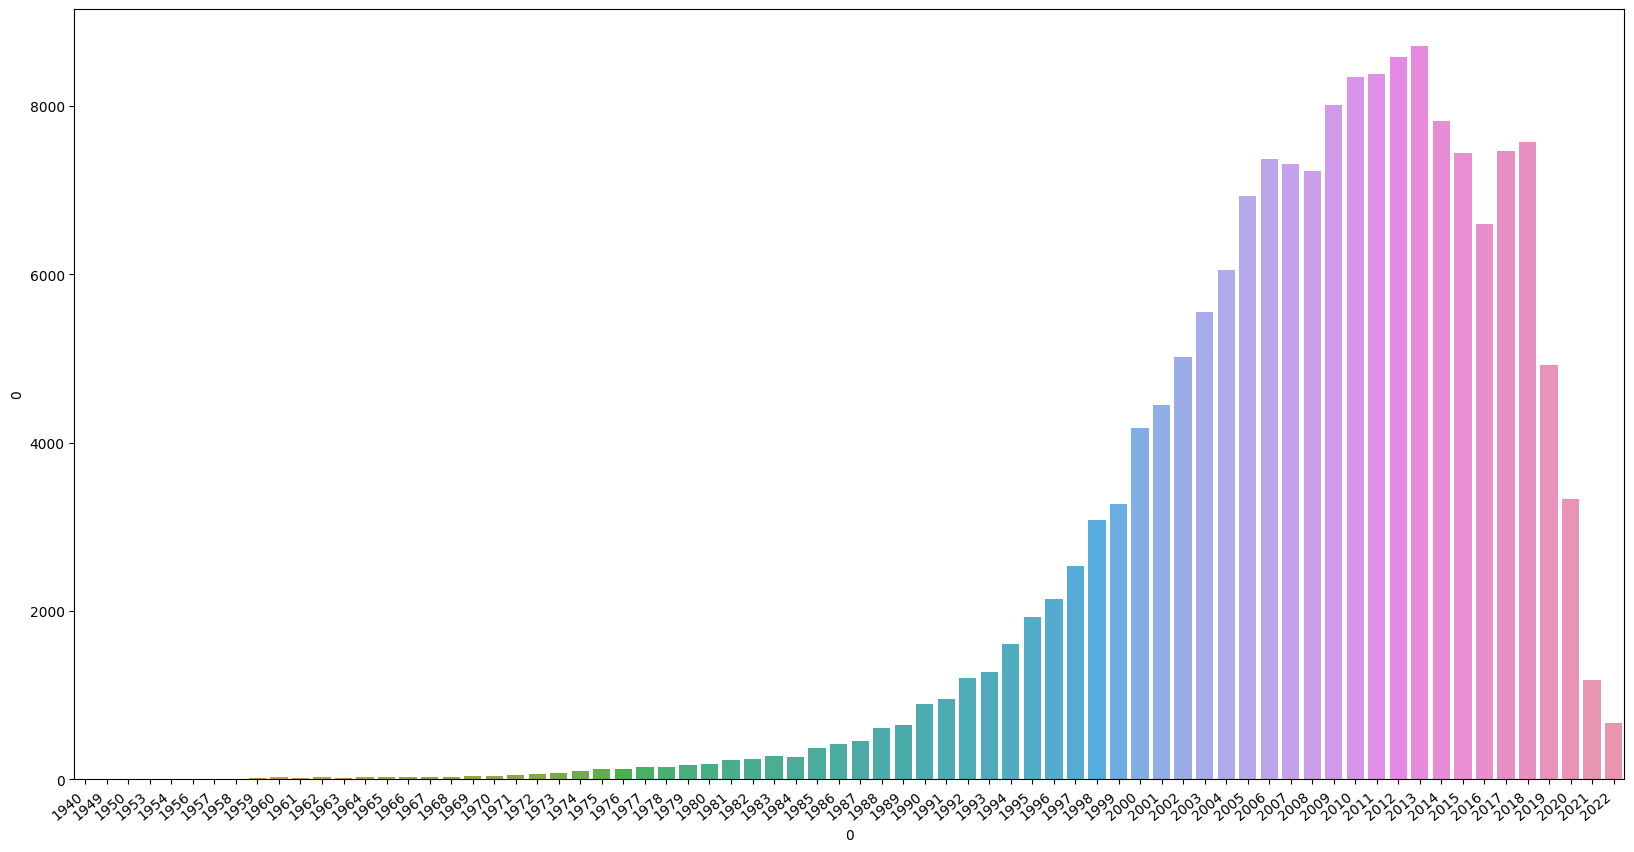

In [17]:
group_by_df = pd.DataFrame(year_df.groupby(year_df[0])[0].count())
plt.figure(figsize=(20,10))
ax = sns.barplot(data=group_by_df, x=group_by_df.index, y=group_by_df[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.savefig('year.png')

### Text cleaning

In [ ]:
# Represent each abstract as a list of words
for node in abstracts:
    abstracts[node] = text_cleaning(abstracts[node])

### Emdeddings 

In [18]:
vector_size = 512

#### Text Emdeddings

##### Doc2Vec

* Each document is represented as a sequence of words obtained by splitting the abstracts. The model is configured with a vector size of 512, indicating that each word and document will be represented by a 512-dimensional vector.The training process involves optimizing the model parameters using the distributed memory (dm) algorithm, which predicts words given their context. Negative sampling is employed with a negative sampling count of 5, which helps to train the model efficiently. Hierarchical softmax (hs) is disabled in this case. Additionally, words with a minimum count of 2 are considered during training, while 8 worker threads are utilized to parallelize the training process. The model is trained for 15 epochs, which means the entire dataset is iterated over 15 times to refine the model's embeddings

In [ ]:
# Train doc2vec algorithm
#documents = [TaggedDocument(abstracts[node].split(), [node]) for node in abstracts]
#model2 = Doc2Vec(documents, vector_size=vector_size, dm=0, negative=5, hs=0, min_count=2, workers=8, epochs=15)
#model2.save("doc2vec.model")

In [19]:
model2 = Doc2Vec.load("doc2vec.model")

#### Graph Emdeddings

##### Deep Walk

In [20]:
def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
    for _ in range(walk_length-1):
        nbrs = list(G.neighbors(walk[-1]))
        if len(nbrs) == 0:
            return walk
        next_node = choice(nbrs)
        walk.append(next_node)
    return walk

def generate_walks(G, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = list()
    for i in range(num_walks):
        for node in G.nodes():
            walk = random_walk(G, node, walk_length)
            walks.append(walk)
    return walks

* Random walks are generated on an undirected graph G using the generate_walks() function. The num_walks parameter controls the number of walks to be generated, and walk_length determines the length of each individual walk.After generating the walks, a Word2Vec model is trained using these walks as the training data. The sentences parameter of the Word2Vec class is set to walks, indicating that the generated walks will be used as the input sentences for training. The model is configured with a vector size of 512, which determines the dimensionality of the word embeddings. A window size of 5 is used, indicating the maximum distance between the current and predicted word within a sentence. A min_count of 0 means that words occurring less than 0 times will not be ignored during training. The model is trained for 7 epochs, meaning the training process will iterate over the dataset 7 times to learn the word embeddings. It utilizes 8 worker threads for parallel processing during training.

In [ ]:
#walks = generate_walks(G.to_undirected(), num_walks=20, walk_length=50)

In [ ]:
#model1 = Word2Vec(sentences=walks, vector_size=vector_size, window=5, min_count=0, epochs=7, workers=8)
#model1.save("word2vec.model")

In [21]:
model1 = Word2Vec.load("word2vec.model")

#### Authors Emdeddings

*  Transform author labels into binary vectors. The resulting author_features matrix represents the encoded features for each author, where each row corresponds to an author and each column represents a unique author label.

In [ ]:
#author_encoder = MultiLabelBinarizer()
#author_features = author_encoder.fit_transform(authors.values())
#authors = dict(zip(authors.keys(), author_features))
#authors = dict(zip(authors.keys(), author_features))

In [22]:
G2 = nx.Graph()
paper_to_authors = dict()
with open("authors_v2.txt", "r") as f:
    for line in f:
        t = line.split('||')
        authors = t[1].split('|*')
        authors[-1] = authors[-1][:-1]
        paper_to_authors[int(t[0])] = authors
        for author in authors:
            if not G2.has_node(author):
                G2.add_node(author)
        for i in range(len(authors)-1):
            for j in range(i+1, len(authors)):
                G2.add_edge(authors[i], authors[j])

In [ ]:
#walks_authors = generate_walks(G, num_walks=10, walk_length=20)

#model_authors = Word2Vec(sentences=walks_authors, vector_size=vector_size, window=5, min_count=0, epochs=7, workers=8)
#model_authors.save("word2vecauthors.model")

In [23]:
model3 = Word2Vec.load("word2vecauthors.model")

#### Year Embeddings

* This code creates a binary matrix year_features where each row represents a sorted year index and each column represents a specific year. The matrix is filled with 1s at the indices corresponding to the sorted years in the year dictionary.

In [24]:
# Sort and extract the indices.
idx = sorted(year.values())
# Initialise a matrix of zeros.
year_features = np.zeros((len(idx), max(idx) + 1))
# Assign 1 to appropriate indices.
year_features[np.arange(len(year_features)), idx] = 1

In [25]:
years = dict(zip(year.keys(), year_features))

#### Concatenate Emdeddings 

In [26]:
X_train1 = np.zeros((len(train_papers),vector_size))
for i, node in enumerate(train_papers):
    X_train1[i,:] = model1.wv[node]

X_train2 = np.zeros((len(train_papers),vector_size))
for i,node in enumerate(train_papers):
    X_train2[i,:] += model2.dv[node]

X_train3 = np.zeros((len(train_papers),vector_size))
for i, node in enumerate(train_papers):
    for author in paper_to_authors[node]:
        X_train3[i,:] += model3.wv[author]
    X_train3[i,:] /= len(paper_to_authors[node])

# Construct test matrix
# Set the representation of each abstract equal to its doc2vec embedding

X_test1 = np.zeros((len(test_papers),vector_size))
for i, node in enumerate(test_papers):
    X_test1[i,:] = model1.wv[node]
    
X_test2 = np.zeros((len(test_papers),vector_size))
for i,node in enumerate(test_papers):
    X_test2[i,:] += model2.dv[node]

X_test3 = np.zeros((len(test_papers),vector_size))
for i, node in enumerate(test_papers):
    for author in paper_to_authors[node]:
        X_test3[i,:] += model3.wv[author]
    X_test3[i,:] /= len(paper_to_authors[node])

In [27]:
X_train = np.concatenate((X_train1, X_train2, X_train3), axis=1)
X_test = np.concatenate((X_test1, X_test2, X_test3), axis=1)

In [28]:
X_train.shape

(35163, 1536)

In [29]:
X_test.shape

(4023, 1536)

#### Split to train/dev sets 

* We split our train set to train and dev set, due to the fact that we have the limitation of submissions in Kaggle platform.

In [30]:
X_train_sp, X_dev, y_train_sp, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED, shuffle=True, stratify=y_train)

#### SVD

* We used TruncatedSVD in order to decrease the number of features (dimensionality reduction). We tried to keep at least the 99.5% of the total dataset's variance. 

In [ ]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components

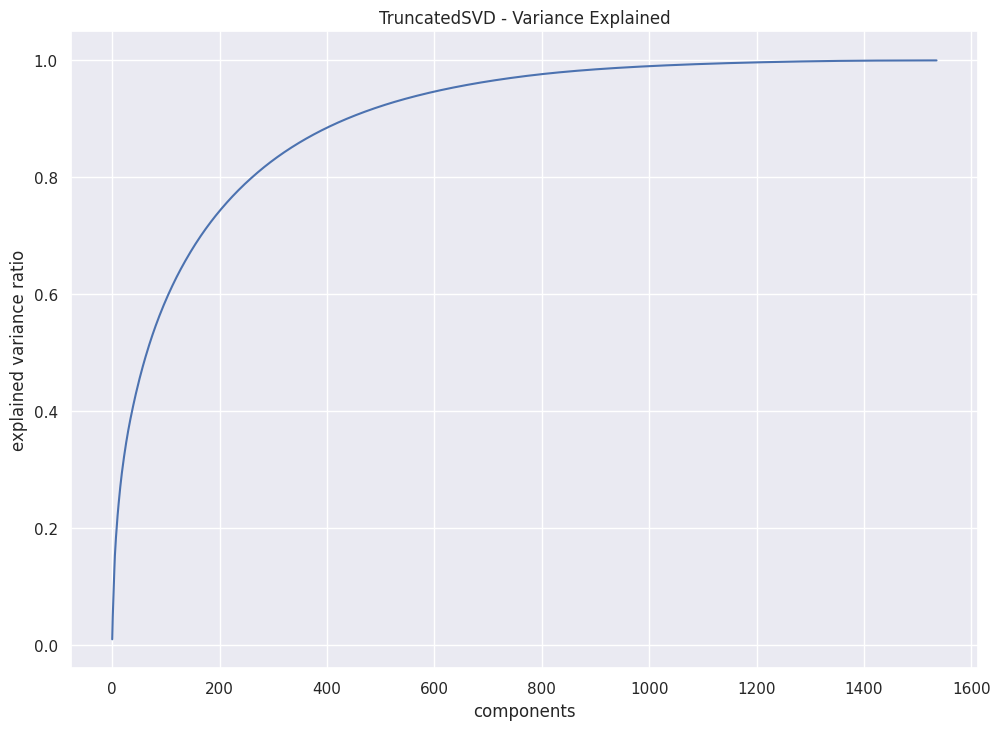

Number of components for 99.5%:  1136


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=X_train_sp.shape[1], random_state=42)
svd.fit(X_train)

plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('TruncatedSVD - Variance Explained')
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.show()

k = select_n_components(svd.explained_variance_ratio_, 0.995)
print("Number of components for 99.5%: ", k)

* Transform each fearure set using the TruncatedSVD with k features.

In [ ]:
svd = TruncatedSVD(n_components=k, random_state=42)
svd.fit(X_train)
X_train_sp_trunc = svd.transform(X_train_sp)
X_train_trunc = svd.transform(X_train)
X_dev_trunc = svd.transform(X_dev)
X_test_trunc = svd.transform(X_test)

In [ ]:
print('Size of training matrix:', X_train_sp_trunc.shape)
print('Size of dev matrix:', X_dev_trunc.shape)
print('Size of unlabeled test matrix:', X_test_trunc.shape)

Size of training matrix: (29888, 1136)
Size of dev matrix: (5275, 1136)
Size of unlabeled test matrix: (4023, 1136)


#### SMOTE

* In this code snippet, an instance of the SMOTE (Synthetic Minority Over-sampling Technique) algorithm is created. SMOTE is a technique used for oversampling imbalanced datasets by generating synthetic samples of the minority class. The 'minority' argument is passed to the SMOTE constructor, indicating that the algorithm should focus on oversampling the minority class. 

In [ ]:
smote = SMOTE( random_state = 42)

In [ ]:
X_train_sp_trunc_res, y_train_sp_res = smote.fit_resample(X_train_sp_trunc, y_train_sp)

In [ ]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
count = Counter(y_train_res)
df_sm = pd.DataFrame.from_dict(count, orient='index')
df_sm = df_sm.sort_index()

In [ ]:
Counter(y_train_res)

Counter({'4': 9825, '3': 9825, '0': 9825, '2': 9825, '1': 9825})

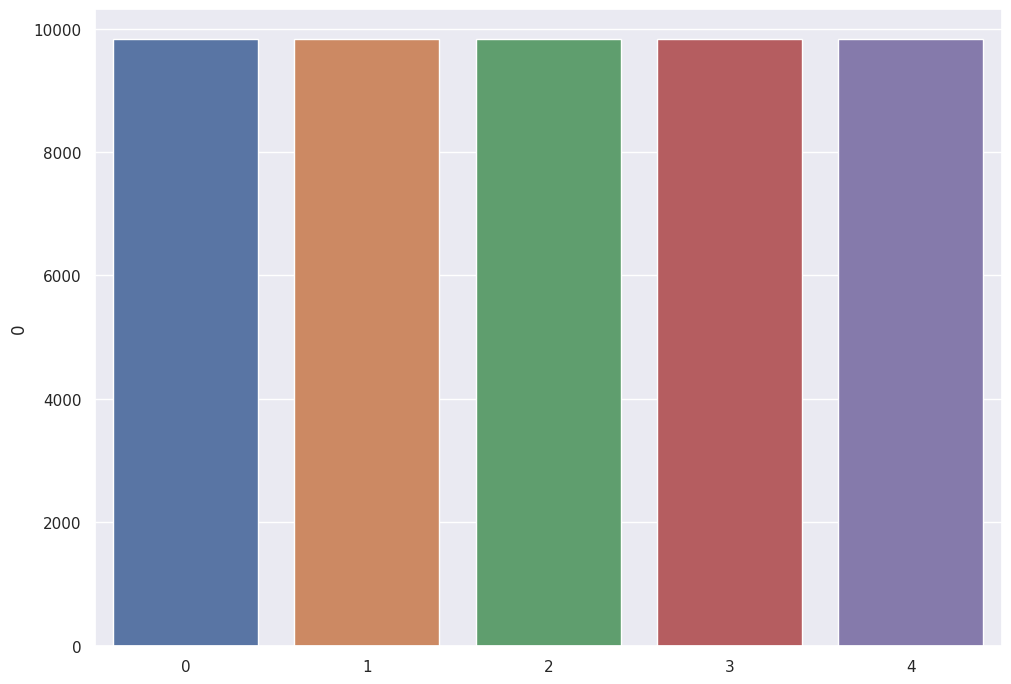

In [ ]:
sns.barplot(data=df_sm, x=df_sm.index, y=df_sm[0]).figure.savefig("class_smote.png")

### Modeling

### SDNE 

In [31]:
from scipy.sparse import identity, diags, csr_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [32]:
def normalize_adjacency(A):
    n = A.shape[0]
    A = A + identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D_inv = diags(inv_degs)
    A_hat = D_inv.dot(A)
    return A_hat


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def loss_function(z, adj, device):
    """Implements loss function"""
    mse_loss = nn.MSELoss()
    sigmoid = nn.Sigmoid()

    y = list()
    y_pred = list()
    
    indices = adj._indices()
    y.append(torch.ones(indices.size(1)).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[indices[0,:]],z[indices[1],:]), dim=1)))

    rand_indices = torch.randint(z.size(0), indices.size())
    y.append(torch.zeros(rand_indices.size(1)).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[rand_indices[0,:]],z[rand_indices[1],:]), dim=1)))
    
    y = torch.cat(y, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    loss = mse_loss(y_pred, y)

    return loss

In [74]:
class GAE(nn.Module):
    """GAE model"""
    def __init__(self, n_nodes, n_feat, n_hidden, dropout):
        super(GAE, self).__init__()
        self.emb = nn.Embedding(n_nodes, n_hidden)
        self.fc1 = nn.Linear(n_hidden, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        e1 = self.emb(x_in)
        
        z1 = self.fc1(e1)
        h1 = self.relu(torch.mm(adj, z1))
        h1 = self.dropout(h1)
        
        z2 = self.fc2(h1)
        h2 = self.relu(torch.mm(adj, z2))
        h2 = self.dropout(h2)
        
        z3 = self.fc3(h2)
        h3 = torch.mm(adj, z3)
        return h3


In [75]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden = 256
learning_rate = 0.001
dropout_rate = 0.2
n = G.number_of_nodes()

In [77]:
adj = nx.adjacency_matrix(G.to_undirected()) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

# Generates node features
features = np.arange(n)

In [78]:
features = torch.LongTensor(features).to(device)
adj = sparse_to_torch_sparse(adj).to(device)

# Creates the model and specifies the optimizer
model = GAE(n, features.shape[0], n_hidden, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [82]:
# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    z = model(features, adj)
    loss = loss_function(z, adj, device)
    with torch.no_grad():
      loss.backward()
      optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss.item()),
              'time: {:.4f}s'.format(time.time() - t))


Epoch: 0001 loss_train: 0.2707 time: 0.6627s
Epoch: 0011 loss_train: 0.2395 time: 0.6185s
Epoch: 0021 loss_train: 0.2224 time: 0.6218s
Epoch: 0031 loss_train: 0.1996 time: 0.6203s
Epoch: 0041 loss_train: 0.1907 time: 0.6231s
Epoch: 0051 loss_train: 0.1857 time: 0.6283s
Epoch: 0061 loss_train: 0.1807 time: 0.6181s
Epoch: 0071 loss_train: 0.1765 time: 0.6457s
Epoch: 0081 loss_train: 0.1737 time: 0.6221s
Epoch: 0091 loss_train: 0.1705 time: 0.6402s


In [83]:
model.eval()
z = model(features, adj)
z = z.detach().cpu().numpy()

# Map nodes to their indices
node_to_idx = dict()
for i, node in enumerate(G.nodes()):
    node_to_idx[node] = i

In [84]:
import gc
gc.collect()
loss = None
torch.cuda.empty_cache()

#### NN 1

In [ ]:
input_layer_size = X_train.shape[1]            # Dimension of features
hidden_layer_size = input_layer_size*2   # of units in hidden layer
output_layer_size = len(set(y_train))     # number of labels

inputs2 = Input(shape=(input_layer_size))

x = Dense(hidden_layer_size, activation='relu')(inputs2) #100 hidden units with RELU activation

x = Dropout(0.5)(x)

outputs2 = Dense(output_layer_size, activation='softmax')(x)

modelnn1 = Model(inputs=inputs2, outputs=outputs2, name='NN_for_doc_vecs')

In [ ]:
eta = 0.00001
decay_rate = 0.00001

#For the first epochs we make the Word2Vec wights not trainable
modelnn1.summary()

#Compiling the model
modelnn1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=eta, weight_decay=decay_rate),
    metrics=['accuracy']
)

Model: "NN_for_doc_vecs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1536)]            0         
                                                                 
 dense (Dense)               (None, 3072)              4721664   
                                                                 
 dropout (Dropout)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 15365     
                                                                 
Total params: 4,737,029
Trainable params: 4,737,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs1 = 200
batch_size = 256

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
#Fitting and showing the results at each epoch
history = modelnn1.fit(
    X_train_sp,
    np.array(y_train_sp).astype(int),
    epochs=epochs1,
    batch_size=batch_size,
    validation_data=(X_dev,np.array(y_dev).astype(int)),
    verbose=1,
    callbacks=[es]
)

Epoch 1/200
117/117 [==============================] - 34s 213ms/step - loss: 1.0307 - accuracy: 0.6473 - val_loss: 0.5896 - val_accuracy: 0.8679
Epoch 2/200
117/117 [==============================] - 23s 193ms/step - loss: 0.5095 - accuracy: 0.8657 - val_loss: 0.4065 - val_accuracy: 0.8836
Epoch 3/200
117/117 [==============================] - 23s 198ms/step - loss: 0.3900 - accuracy: 0.8880 - val_loss: 0.3479 - val_accuracy: 0.8906
Epoch 4/200
117/117 [==============================] - 21s 180ms/step - loss: 0.3407 - accuracy: 0.8941 - val_loss: 0.3201 - val_accuracy: 0.8925
Epoch 5/200
117/117 [==============================] - 26s 220ms/step - loss: 0.3126 - accuracy: 0.8992 - val_loss: 0.3034 - val_accuracy: 0.8948
Epoch 6/200
117/117 [==============================] - 22s 186ms/step - loss: 0.2930 - accuracy: 0.9029 - val_loss: 0.2925 - val_accuracy: 0.8974
Epoch 7/200
117/117 [==============================] - 23s 200ms/step - loss: 0.2786 - accuracy: 0.9076 - val_loss: 0.2843 -

##### Model History

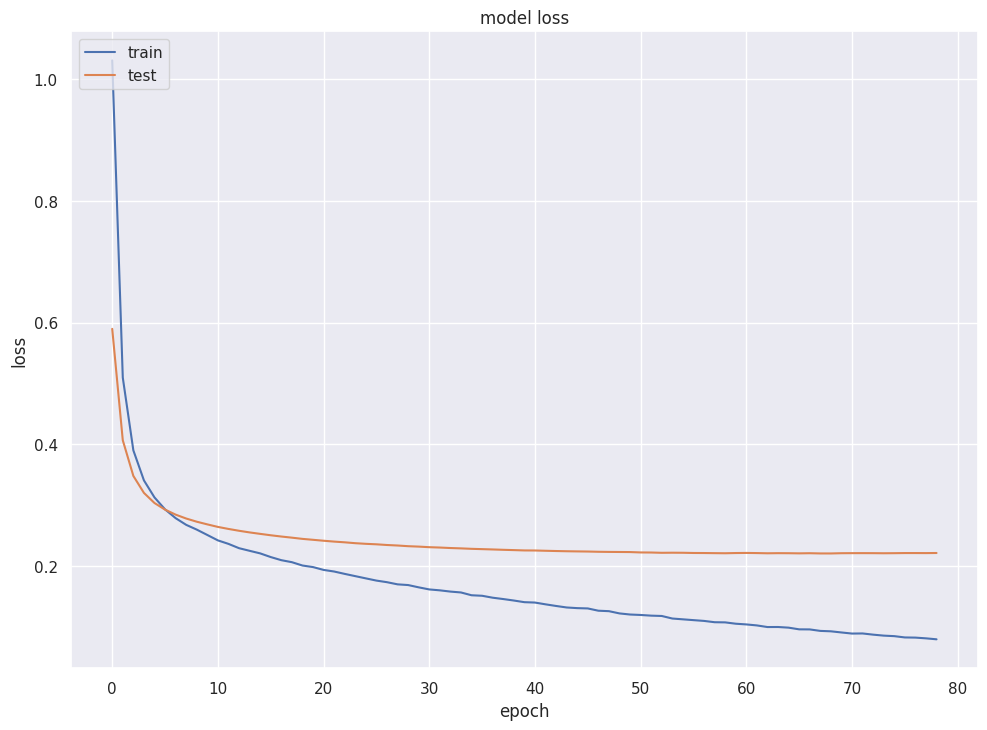

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Model Evaluation

In [ ]:
score= modelnn1.evaluate(X_dev,np.array(y_dev).astype(int),
                            batch_size=batch_size)

print('Test Loss:\t', score[0])
print('Test Accuracy:\t', score[1])

21/21 [==============================] - 2s 79ms/step - loss: 0.2205 - accuracy: 0.9181
Test Loss:	 0.22054898738861084
Test Accuracy:	 0.9181042909622192


In [41]:
encoder = LabelEncoder()
encoder.fit(y_dev)
encoded_Y = encoder.transform(y_dev)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
pred_dev = modelnn1.predict(X_dev)

print('log_loss: %.3f' % log_loss(dummy_y, pred_dev))
print(classification_report(np.argmax(dummy_y, axis=1), np.argmax(pred_dev, axis=1)))

165/165 [==============================] - 2s 14ms/step
log_loss: 0.221
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1273
           1       0.94      0.96      0.95      1405
           2       0.93      0.91      0.92       643
           3       0.91      0.92      0.91      1474
           4       0.96      0.95      0.95       480

    accuracy                           0.92      5275
   macro avg       0.92      0.92      0.92      5275
weighted avg       0.92      0.92      0.92      5275



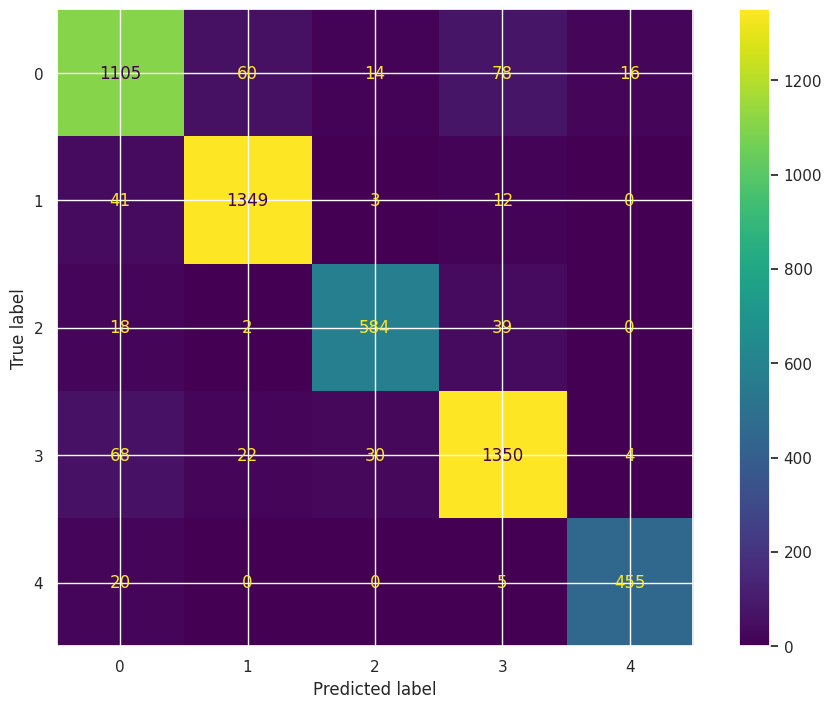

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(np.argmax(dummy_y, axis=1), np.argmax(pred_dev, axis=1)))
disp.plot()
disp.figure_.savefig('confusion_matrix_nn.png')

#### LGBM Classifier

In [34]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_sp),
                                                 y = y_train_sp)
class_weights = dict(zip(np.unique(y_train_sp).astype(int), class_weights))
class_weights

{0: 0.828840820854132,
 1: 0.7509547738693467,
 2: 1.641295991213619,
 3: 0.715794515626871,
 4: 2.195225853837679}

In [ ]:
clf = lgb.LGBMClassifier(class_weight =class_weights, n_jobs=1)
clf.fit(X_train_sp, np.array(y_train_sp).astype(int))

LGBMClassifier(class_weight={0: 0.828840820854132, 1: 0.7509547738693467,
                             2: 1.641295991213619, 3: 0.715794515626871,
                             4: 2.195225853837679},
               n_jobs=1)

In [ ]:
pred_proba_train_clf = clf.predict_proba(X_train_sp)
pred_train_clf = clf.predict(X_train_sp)
pred_proba_dev_clf = clf.predict_proba(X_dev)
pred_dev_clf = clf.predict(X_dev)

print("log loss")
print("train", log_loss(y_train_sp, pred_proba_train_clf),"dev", log_loss(y_dev, pred_proba_dev_clf))
print("accuracy_score")
print("train", accuracy_score(np.array(y_train_sp).astype(int), pred_train_clf), "dev", accuracy_score(np.array(y_dev).astype(int), pred_dev_clf))

log loss
train 0.04723430935318619 dev 0.2493429498639242
accuracy_score
train 0.9990966274089935 dev 0.9093838862559241


In [ ]:
print('log_loss: %.3f' % log_loss(dummy_y, pred_proba_dev_clf))
print(classification_report(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_clf, axis=1)))

log_loss: 0.249
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1273
           1       0.93      0.95      0.94      1405
           2       0.92      0.92      0.92       643
           3       0.91      0.90      0.91      1474
           4       0.93      0.94      0.93       480

    accuracy                           0.91      5275
   macro avg       0.91      0.91      0.91      5275
weighted avg       0.91      0.91      0.91      5275



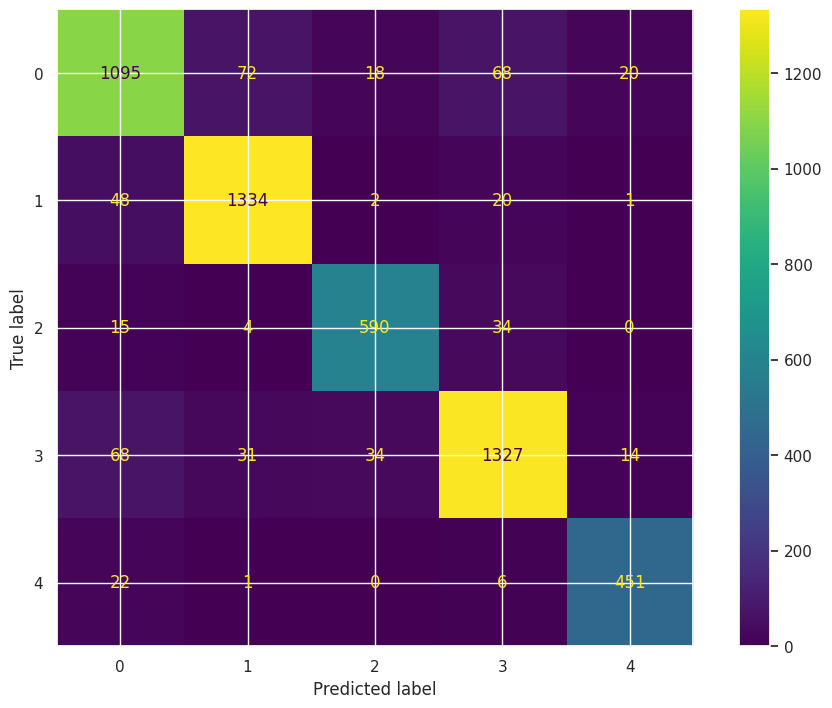

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_clf, axis=1)))
disp.plot()
disp.figure_.savefig('confusion_matrix_lgbm.png')

#### XGB Classifier

In [ ]:
clf2 = XGBClassifier(n_jobs=-1, sample_weight=class_weights)
clf2.fit(X_train_sp, np.array(y_train_sp).astype(int))

[10:25:17] WARNING: ../src/learner.cc:767: 
Parameters: { "sample_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
pred_proba_train_clf2 = clf2.predict_proba(X_train_sp)
pred_train_clf2 = clf2.predict(X_train_sp)
pred_proba_dev_clf2 = clf2.predict_proba(X_dev)
pred_dev_clf2 = clf2.predict(X_dev)

print("log loss")
print("train", log_loss(y_train_sp, pred_proba_train_clf2),"dev", log_loss(y_dev, pred_proba_dev_clf2))
print("accuracy_score")
print("train", accuracy_score(np.array(y_train_sp).astype(int), pred_train_clf2), "dev", accuracy_score(np.array(y_dev).astype(int), pred_dev_clf2))

log loss
train 0.003816238105725329 dev 0.26895684885617377
accuracy_score
train 1.0 dev 0.9103317535545024


In [ ]:
print('log_loss: %.3f' % log_loss(dummy_y, pred_proba_dev_clf2))
print(classification_report(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_clf2, axis=1)))

log_loss: 0.269
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1273
           1       0.93      0.95      0.94      1405
           2       0.92      0.91      0.91       643
           3       0.90      0.91      0.91      1474
           4       0.95      0.93      0.94       480

    accuracy                           0.91      5275
   macro avg       0.92      0.91      0.91      5275
weighted avg       0.91      0.91      0.91      5275



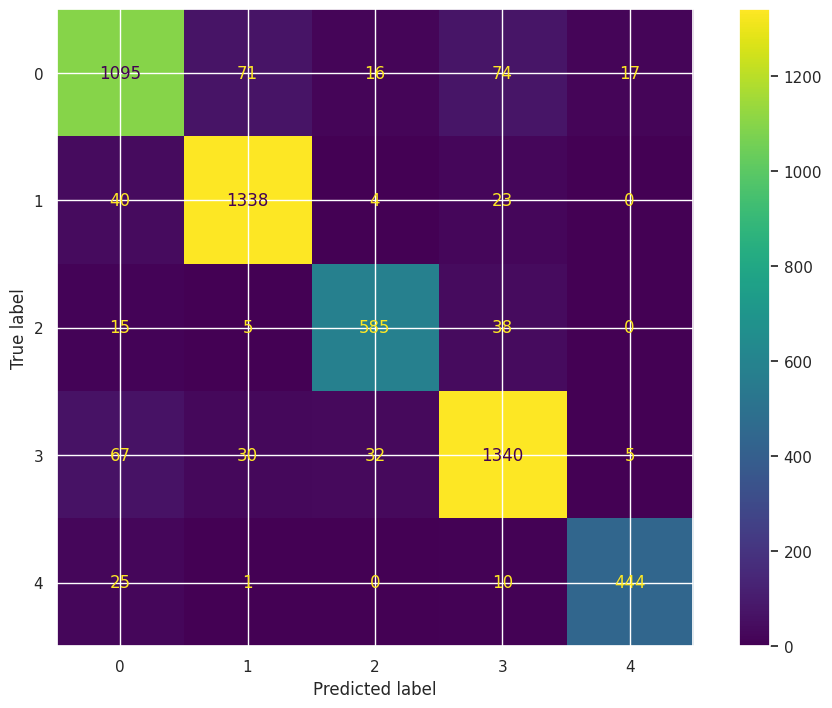

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_clf2, axis=1)))
disp.plot()
disp.figure_.savefig('confusion_matrix_xgb.png')

#### Voting Classifier

In [35]:
input_layer_size = X_train.shape[1]            # Dimension of features
hidden_layer_size = input_layer_size*2   # of units in hidden layer
output_layer_size = len(set(y_train))     # number of labels

inputs2 = Input(shape=(input_layer_size))

x = Dense(hidden_layer_size, activation='relu')(inputs2) #100 hidden units with RELU activation

x = Dropout(0.5)(x)

outputs2 = Dense(output_layer_size, activation='softmax')(x)

modelnn1 = Model(inputs=inputs2, outputs=outputs2, name='NN_for_doc_vecs')

In [36]:
eta = 0.00001
decay_rate = 0.00001

#For the first epochs we make the Word2Vec wights not trainable
modelnn1.summary()

#Compiling the model
modelnn1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=eta, weight_decay=decay_rate),
    metrics=['accuracy']
)

print(eta)

Model: "NN_for_doc_vecs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1536)]            0         
                                                                 
 dense_2 (Dense)             (None, 3072)              4721664   
                                                                 
 dropout_1 (Dropout)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 15365     
                                                                 
Total params: 4,737,029
Trainable params: 4,737,029
Non-trainable params: 0
_________________________________________________________________
1e-05


In [37]:
epochs1 = 75
batch_size = 256

keras_clf = KerasClassifier(
                            modelnn1,
                            epochs=epochs1,
                            verbose=False,
                            batch_size = batch_size,
                            optimizer=keras.optimizers.Adam(learning_rate=eta, weight_decay=decay_rate),
                            loss='sparse_categorical_crossentropy'
                            )

clf = lgb.LGBMClassifier(class_weight=class_weights , n_jobs=1)
clf2 = XGBClassifier(sample_weight=class_weights, n_jobs=-1)

In [38]:
eclf = VotingClassifier(estimators=[('lgbm', clf), ('xgb', clf2), ('nn', keras_clf)],
                         voting='soft', weights=[3, 2, 3])
eclf.fit(X_train_sp, np.array(y_train_sp).astype(int))

[17:44:31] WARNING: ../src/learner.cc:767: 
Parameters: { "sample_weight" } are not used.



VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(class_weight={0: 0.828840820854132,
                                                           1: 0.7509547738693467,
                                                           2: 1.641295991213619,
                                                           3: 0.715794515626871,
                                                           4: 2.195225853837679},
                                             n_jobs=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('nn',
                              KerasClassifier(batch_size=256, epochs=75, loss='sparse_categorical_crossentropy', model=<keras.engine.functional.Functional object at 0x7f6720093310>, optimizer=<keras.optimizers.adam.Adam object at 0x7f6720093700>, verbose=False))],
                 voting='soft', weights=[3, 2, 3])

In [39]:
pred_proba_train_eclf = eclf.predict_proba(X_train_sp)
pred_train_eclf = eclf.predict(X_train_sp)
pred_proba_dev_eclf = eclf.predict_proba(X_dev)
pred_dev_eclf = eclf.predict(X_dev)

print("log loss")
print("train", log_loss(y_train_sp, pred_proba_train_eclf),"dev", log_loss(y_dev, pred_proba_dev_eclf))
print("accuracy_score")
print("train", accuracy_score(np.array(y_train_sp).astype(int), pred_train_eclf), "dev", accuracy_score(np.array(y_dev).astype(int), pred_dev_eclf))

log loss
train 0.04150904860390722 dev 0.21790464957300998
accuracy_score
train 0.9988624197002142 dev 0.9196208530805687


In [42]:
print('log_loss: %.3f' % log_loss(dummy_y, pred_proba_dev_eclf))
print(classification_report(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_eclf, axis=1)))

log_loss: 0.218
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1273
           1       0.94      0.96      0.95      1405
           2       0.92      0.92      0.92       643
           3       0.92      0.92      0.92      1474
           4       0.95      0.94      0.95       480

    accuracy                           0.92      5275
   macro avg       0.92      0.92      0.92      5275
weighted avg       0.92      0.92      0.92      5275



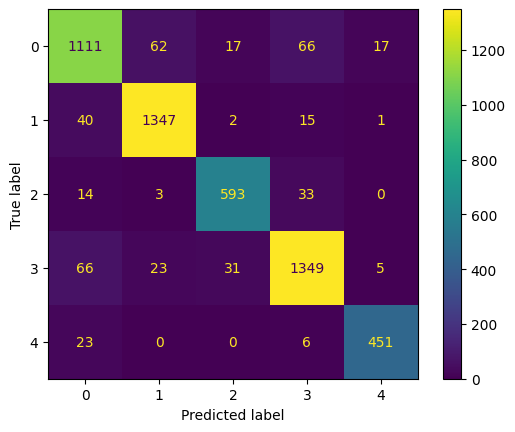

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix(np.argmax(dummy_y, axis=1), np.argmax(pred_proba_dev_eclf, axis=1)))
disp.plot()
disp.figure_.savefig('confusion_matrix_xgb.png')

### Train with whole dataset

#### Voting Classifier

##### Class weights

In [26]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = dict(zip(np.unique(y_train).astype(int), class_weights))
class_weights

{0: 0.8288273423688862,
 1: 0.7509450080085425,
 2: 1.641213535589265,
 3: 0.7157862595419847,
 4: 2.1956290977208868}

##### NN Classifier for KerasClassifier

In [27]:
input_layer_size = X_train.shape[1]            # Dimension of features
hidden_layer_size = input_layer_size*2   # of units in hidden layer
output_layer_size = len(set(y_train))     # number of labels

inputs2 = Input(shape=(input_layer_size))

x = Dense(hidden_layer_size, activation='relu')(inputs2) #100 hidden units with RELU activation

x = Dropout(0.5)(x)

outputs2 = Dense(output_layer_size, activation='softmax')(x)

modelnn1 = Model(inputs=inputs2, outputs=outputs2, name='NN_for_doc_vecs')

In [28]:
eta = 0.00001
decay_rate = 0.00001

#For the first epochs we make the Word2Vec wights not trainable
modelnn1.summary()

#Compiling the model
modelnn1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=eta, weight_decay=decay_rate),
    metrics=['accuracy']
)

print(eta)

Model: "NN_for_doc_vecs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1536)]            0         
                                                                 
 dense (Dense)               (None, 3072)              4721664   
                                                                 
 dropout (Dropout)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 15365     
                                                                 
Total params: 4,737,029
Trainable params: 4,737,029
Non-trainable params: 0
_________________________________________________________________
1e-05


In [29]:
epochs1 = 75
batch_size = 256

keras_clf = KerasClassifier(
                            modelnn1,
                            epochs=epochs1,
                            verbose=False,
                            batch_size = batch_size,
                            optimizer=keras.optimizers.Adam(learning_rate=eta, weight_decay=decay_rate),
                            loss='sparse_categorical_crossentropy'
                            )

clf = lgb.LGBMClassifier(class_weight=class_weights , n_jobs=1)
clf2 = XGBClassifier(sample_weight=class_weights, n_jobs=-1)

In [30]:
eclf = VotingClassifier(estimators=[('lgbm', clf), ('xgb', clf2), ('nn', keras_clf)],
                         voting='soft', weights=[3, 2, 3])
eclf.fit(X_train, np.array(y_train).astype(int))

[15:10:24] WARNING: ../src/learner.cc:767: 
Parameters: { "sample_weight" } are not used.



VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(class_weight={0: 0.8288273423688862,
                                                           1: 0.7509450080085425,
                                                           2: 1.641213535589265,
                                                           3: 0.7157862595419847,
                                                           4: 2.1956290977208868},
                                             n_jobs=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_ca...
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('nn',
                              KerasClassifier(batch_size=256, epochs=75, loss='sparse_categorical_crossentropy', model=<keras.engine.functional.Functional object at 0x7f6800e37940>, optimizer=<keras.optimizers.adam.Adam object at 0x7f6800e36a10>, verbose=False))],
                 voting='soft', weights=[3, 2, 3])

### Prediction

#### Voting Classifier

In [31]:
y_pred = eclf.predict_proba(X_test)

### Submission

In [32]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(5):
        lst.append('class_'+str(i))
    lst.insert(0, "paperID")
    writer.writerow(lst)
    for i,test_paper in enumerate(test_papers):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_paper)
        writer.writerow(lst)